# Data Analysis 
# Linear Regression 2

In this lecture, we'll discuss:
* overfitting, model generalizability, and the bias-variance tradeoff
* cross validation 
* regularization
* extensions of the linear model

Recommended reading:
* G. James, D. Witten, T. Hastie, and R. Tibshirani, An Introduction to Statistical Learning, Ch. 5.1, 6.1, 6.2 [digital version available here](https://www.statlearning.com/)

* Sebastian Raschka: Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning (https://arxiv.org/abs/1811.12808)


# 0. Review from previous lecture

### Simple Linear Regression (SLR)

**Data**: We have $n$ samples $(x, y)_i$, $i=1,\ldots n$. 

**Model**: $y \sim \beta_0 + \beta_1 x$ 

**Goal**: Find the best values of $\beta_0$ and $\beta_1$, denoted $\hat{\beta}_0$ and $\hat{\beta}_1$, so that the prediction $y = \hat{\beta}_0 + \hat{\beta}_1 x$ "best fits" the data. 

<img src="438px-Linear_regression.png" width="40%" alt="https://en.wikipedia.org/wiki/Linear_regression">

**Theorem.** 
The parameters that minimize the "residual sum of squares (RSS)", 
$RSS = \sum_i (y_i - \beta_0 - \beta_1 x_i)^2$, 
are: 
$$
\hat{\beta}_1 = \frac{\sum_{i=1}^n (x_i - \overline{x})(y_i - \overline{y}) }{\sum_{i=1}^n (x_i - \overline{x})^2}
\qquad \textrm{and} \qquad
\hat{\beta}_0 = \overline{y} -  \hat{\beta}_1 \overline{x}. 
$$
where $\overline{x} = \frac{1}{n} \sum_{i=1}^n x_i$ and $\overline{y} = \frac{1}{n} \sum_{i=1}^n y_i$. 


### Multilinear regression 

**Data**: We have $n$ samples of the form $\big(x_1, x_2 , \ldots, x_m , y \big)_i$, $i=1,\ldots n$. 

**Model**: $y \sim \beta_0 + \beta_1 x_1 + \cdots + \beta_m x_m $ 

### Nonlinear relationships  

**Data**: We have $n$ samples $\big(x_1, x_2 , \ldots, x_m , y \big)_i$, $i=1,\ldots n$. 

**Model**: $y \sim \beta_0 + \beta_1 f_1(x_1,x_2,\ldots,x_m) + \cdots +  \beta_k f_k(x_1,x_2,\ldots,x_m)$ 


## 0.1 Regression with python

There are several different python packages that do regression:
1. [statsmodels](http://statsmodels.sourceforge.net/)
+ [scikit-learn](http://scikit-learn.org/)
+ ... 

Last time, we commented that statsmodels approaches regression from a statistics viewpoint, while scikit-learn approaches from a machine learning viewpoint. We will say more about this today. 

In [1]:
# imports and setup

import scipy as sc
import numpy as np

import pandas as pd
import statsmodels.formula.api as sm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from IPython.display import Video

import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## 0.2 Advertisement dataset
Consider the 'Advertising' dataset from
[here](http://www-bcf.usc.edu/~gareth/ISL/data.html).


For 200 different ‘markets’ (think different cities), this dataset consists of the number of sales of a particular product as well as the advertising budget for three different media: TV, radio, and newspaper. 

Last time, after trying a variety of linear models, we discovered the following one, which includes a nonlinear relationship between the TV budget and Radio budget:
$$
\text{Sales} = \beta_0 + \beta_1 \times \text{TV_budget} + \beta_2 \times \text{Radio_budget} + \beta_3 \times \text{TV_budget} \times \text{Radio_budget}. 
$$

In [2]:
advert = pd.read_csv('Advertising.csv',index_col=0) #load data

ad_NL = sm.ols(formula="Sales ~ TV + Radio + TV*Radio", data=advert).fit()
ad_NL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1963.
Date:                Mon, 14 Feb 2022   Prob (F-statistic):          6.68e-146
Time:                        10:39:10   Log-Likelihood:                -270.14
No. Observations:                 200   AIC:                             548.3
Df Residuals:                     196   BIC:                             561.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7502      0.248     27.233      0.000       6.261       7.239
TV             0.0191      0.002     12.699      0.000       0.016       0.022
Radio          0.0289      0.009      3.241      0.001       0.011       0.046
TV:Radio       0.0011   5.24e-05     20.727      0.000       0.001       0.001
==============================================================================
Omnibus:                      128.132   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1183.719
Skew:                          -2.323   Prob(JB):                    9.09e-258
Kurtosis:                      13.975   Cond. No.                     1.80e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model is really excellent: 
- $R^2 = 97\%$ of the variability in the data is accounted for by the model. 
- The $p$-value for the F-statistic is very small 
- The $p$-values for the individual coefficients are small 

Interpretation: 
- In a particular market, if I spend an additional $1k on TV advertising, what do I expect sales to do? 
- Should I spend additional money on TV or Radio advertising? 

# 1. Overfitting, underfitting, model generalizability, and the bias–variance tradeoff

In regression, and other prediction problems, we would like to develop a model on a dataset, that would preform well, not only on that dataset, but on similar data that the model hasn't yet seen by the model. If a model satisfies this criterion, we say that it is *generalizable*. 

Consider the following data, that has been fit with a linear polynomial model (black) and a high degree polynomial model (blue). For convenience, let us call these the black and blue models, respectively. 

<img src="overfitted_data.png" title="https://commons.wikimedia.org/w/index.php?curid=47471056" width="40%">

Let's call the dataset that we train the model on the *training dataset* and the dataset that we test the model on the *testing dataset*. In the above figure, the training dataset are the black points and the testing dataset is not shown, but we imagine it to be similar to the points shown. 

Which model is better? 

The blue model has 100% accuracy on the training dataset, while the black model has much smaller accuracy. However, the blue model is highly oscillatory and might not generalize well to new data. For example, the model would wildly miss the test point $(3,0)$. We say that the blue model has *overfit* the data. On the other hand, it isn't difficult to see that we could also *underfit* the data. In this case, the model isn't complex enough to have good accuracy on the training dataset. 

This phenomenon is often described in terms of the *bias-variance tradeoff*. Here, we decompose the error of the model into three terms:
$$
\textrm{Error} = 
\textrm{Bias} + 
\textrm{Variance} + 
\textrm{Irreducible Error}. 
$$
- The *bias* of the method is the error caused by the simplifying assumptions built into the method. 
+ The *variance* of the method is how much the model will change based on the sampled data. 
+ The *irreducible error* is error in the data itself, so no model can capture this error. 

There is a tradeoff between the bias and variance of a model. 
High-variance methods (e.g., the blue method) are accurate on the training set, but overfit noise in the data, so don't generalized well to new data. High-bias models (e.g., the black method) are too simple to fit the data, but are better at generalizing to new test data. 

The dashed line shows us the testing error and the solid line the training error.

![complexity-error-plot](complexity-error-plot.png)

One of the class participants made a meme last year: https://twitter.com/gerasimoss/status/1270326690313646081?s=20


# 2. Generalizability in practice

How do I fit a model in practice? What techniques should I employ in order to make sure that the model is good enough. 

We will discuss three techniques, namely:

* cross-validation, <br>
* regularization, <br>
* step-wise selection <br>

While we discuss the linear model, these techniques are applicable to *any* other model involving learning from data. 

## 2.1 Cross-validation

There is a clever method for developing generalizable models that aren't underfit or overfit, called *cross validation*. 

**Cross-validation** is a general method for assessing how the results of a predictive model (regression, classification,...) will *generalize* to an independent data set. In regression, cross-validation is a method for assessing how well the regression model will predict the dependent value for points that weren't used to *train* the model. 

The idea of the method is simple: 
1. Split the dataset into two groups: the training dataset and the testing dataset. 
+ Train a variety of models on the training dataset. 
+ Check the accuracy of each model on the testing dataset. 
+ By comparing these accuracies, determine which model is best.

As the model becomes more complex ($d$ increases), the accuracy always increases for the training dataset. But, at some point, it starts to overfit the data and the accuracy decreases for the test dataset! Cross validation techniques will allow us to find the sweet-spot for the parameter $d$!

In practice, you have to decide how to split the data into groups (i.e. how large the groups should be). You might also want to repeat the experiment several times ($K$-fold cross validation, see next section) so that the assessment doesn't depend on the way in which you split the data into groups.


Let's see this concept for the relationship between mpg and horsepower in the Auto dataset. We'll use the scikit-learn package for the cross validation analysis instead of statsmodels, because it is much easier to do cross validation there. 

In [3]:
auto = pd.read_csv('Auto.csv') #load data

# one of the horsepowers is '?', so we just remove it and then map the remaining strings to integers
auto = auto[auto.horsepower != '?']
auto['horsepower'] = auto['horsepower'].map(int)

auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


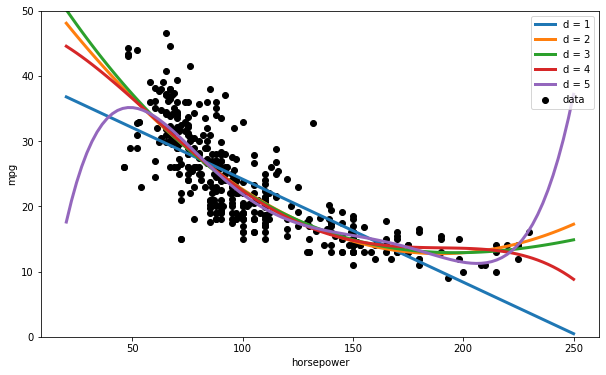

In [4]:
lr = LinearRegression() # create a linear regression object

# with scikit-learn, we have to extract values from the pandas dataframe
for d in np.arange(2,6): 
    auto['h'+str(d)] = auto['horsepower']**d

X = auto[['horsepower','h2','h3','h4','h5']].values.reshape(auto['horsepower'].shape[0],5)
y = auto['mpg'].values.reshape(auto['mpg'].shape[0],1)

plt.scatter(X[:,0], y,  color='black',label='data')

# make data for plotting
xs = np.linspace(20, 250, num=100)
Xs = np.zeros([100,5])
Xs[:,0] = xs
for d in np.arange(1,5): 
    Xs[:,d] = xs**(d+1)
    
for d in np.arange(1,6):     
    lr.fit(X=X[:,:d], y=y)
    plt.plot(xs, lr.predict(X=Xs[:,:d]), linewidth=3, label = "d = " + str(d) )

plt.legend(loc='upper right')
plt.xlabel('horsepower'); plt.ylabel('mpg')
plt.ylim((0,50))
plt.show()

### 2.1.1 Cross validation using scikit-learn 

- In scikit-learn, you can use the [*train_test_split*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to split the dataset into a training dataset and a test dataset. This split is supposed to be random (pay attention to which method you are using and how it does the splitting). Obviously, we might get a bad random split (if we are unlucky). There are ways to control for that (e.g. through K-fold cross validation see below).
+ The *score* function returns the coefficient of determination, $R^2$, of the prediction.

In the following code, I've split the data in an unusual way - taking the test set to be 90% - to illustrate the point more clearly. Typically, we might make the training set to be 70-90% of the dataset. 

(39, 5) (39, 1)
(353, 5) (353, 1)
d= 1 , train:  0.6508117557688201  test:  0.5861089204353647
d= 2 , train:  0.7788726103432309  test:  0.6773426966876412
d= 3 , train:  0.7809007867736247  test:  0.6730819069807141
d= 4 , train:  0.7818275548491538  test:  0.6715071420669175
d= 5 , train:  0.7849846290954009  test:  0.6522245738926651


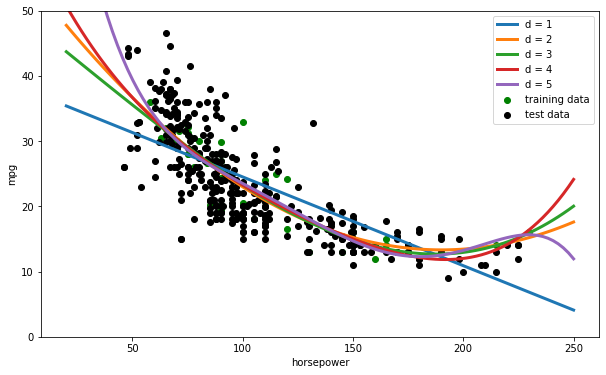

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

plt.scatter(X_train[:,0], y_train,  color='green',label='training data')
plt.scatter(X_test[:,0], y_test,  color='black',label='test data')

for d in np.arange(1,6):     
    lr.fit(X=X_train[:,:d], y=y_train)
    print('d=', d, ', train: ', lr.score(X_train[:,:d], y_train), ' test: ', lr.score(X_test[:,:d], y_test))
    plt.plot(xs, lr.predict(X=Xs[:,:d]), linewidth=3, label = "d = " + str(d) )

plt.legend()
plt.xlabel('horsepower'); plt.ylabel('mpg')
plt.ylim((0,50))
plt.show()


We observe that as the model complexity increases, 
- the accuracy on the training data increases, but 
+ the generalizability of the model to the test set decreases. 

Our job as data scientists is to find a model that is sufficiently complex to describe the training data, but not so complex that it isn't generalizable to new data. 

### 2.1.2 The need for a validation set

Let's think for a moment, how we picked $d$ in the previous example. We selected the best $d$ based on "minimizing" the test set error, which means that we have then "fit for" hyperparameter $d$ on the test set. 

In this case, the test-set error will underestimate the true error (or as we call it in statistical/machine learning the "out of sample" error or generalization error). Furthermore, we have **contaminated the test set** by fitting for $d$ on it; it is no longer a true test set.

Thus, we introduce a new **validation set** on which the complexity parameter $d$ is fit, and leave out a test set which we can use to estimate the true out-of-sample performance of our model. The place of this set in the scheme of things is shown below:

![m:caption](train-validate-test.png)

We have split the old training set into a **new smaller training set** and a **validation set**, holding the old test set aside for *FINAL* testing *AFTER* we have "fit" for complexity $d$. Obviously we have decreased the size of the data available for training further, but this is a price we must pay for obtaining a good estimate of the out-of-sample risk $\cal{E}_{out}$ (also denoted as risk $R_{out}$) through the test risk $\cal{E}_{test}$ ($R_{test}$).

![m:caption](train-validate-test-cont.png)

### 2.1.3 Creating more random splits: $K$-fold cross validation

1. You should worry that a given split exposes us to the peculiarity of the data set that got randomly chosen for us. This naturally leads us to want to choose multiple such random splits and somehow average over this process to find the "best" validation minimizing polynomial degree or complexity $d$.

2. The multiple splits process also allows us to get an estimate of how consistent our prediction error is: in other words, i get a distribution of the prediction error. Using simple statistics, I can quantify how good/bad that is.

3. Furthermore the validation set that we left out has two competing demands on it. The larger the set is, the better is our estimate of the out-of-sample error. So we'd like to hold out as much as possible. But the smaller the validation set is, the more data we have to train our model on. This allows us to have more smaller sets.

The idea is illustrated in the figure below, for a given hypothesis set $\cal{H}_a$ with complexity parameter $d=a$ (the polynomial degree). We do the train/validate split, not once but multiple times. 

In the figure below we create 4-folds from the training set part of our data set $\cal{D}$. By this we mean that we divide our set roughly into 4 equal parts. As illustrated below, this can be done in 4 different ways, or folds. In each fold we train a model on 3 of the parts. The model so trained is denoted as $g^-_{Fi}$, for example $g^-_{F3}$ . The minus sign in the superscript once again indicates that we are training on a reduced set. The $F3$ indicates that this model was trained on the third fold. Note that the model trained on each fold will be different!

For each fold, after training the model, we calculate the risk or error on the remaining one validation part. We then add the validation errors together from the different folds, and divide by the number of folds to calculate an average error. Note again that this average error is an average over different models $g^-_{Fi}$. We use this error as the validation error for $d=a$ in the validation process described earlier.

![traincv](traincv.png) 

In detail, the procedure (we outline it here for the polynomial degree $d$ but in principle could be for any other parameter) and we use the $R^2$ as a risk function of $d$ (again, it could be any other risk or error function):

1. create $K$ partitions of the training data. 
2. We then train on $K-1$ of these partitions, and test on the remaining partition. There are $K$ such combinations of partitions (or folds), and thus we obtain $K$ risk values.
3. We average the error or risk of all such combinations to obtain, for each value of $d$, $R_{d}$.
4. We move on to the next value of $d$, and repeat 3
5. and then find the optimal value of d that minimizes risk $d=*$.
5. We finally use that value to make the final fit in $\cal{H}_*$ on the entire old training set.

#### Variations of cross-validation

There are many different variations of the cross-validation procedure (although the main idea remains the same). One that I find particularly useful when you fit hyperparameters in complex algorithms is the *nested* cross validation.

The *outer loop* splits the data to training/testing. The *inner loop* splits the training data further to the actual training and validation data. In the inner loop, we find the optimal values of hyperparameters by checking their performance on the validation set. In the outer loop, we compute the generalization error by averaging test set scores over the several dataset splits.


### 2.1.4 Meta-estimators in Python

`sklearn` offers many possibilities of automating the cross-validation process. It is important though to understand what each of these (otherwise excellently implemented) functions do, e.g. as the documentation for `GridSearchCV` puts it:

>In scikit-learn, model selection is supported in two distinct meta-estimators, GridSearchCV and RandomizedSearchCV. They take as input an estimator (basic or composite), whose hyper-parameters must be optimized, and a set of hyperparameter settings to search through.

The concept of a meta-estimator allows us to wrap, for example, cross-validation, or methods that build and combine simpler models or schemes. For example:

    est = LinearRegression()
    parameters = {"d": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
    gridclassifier=GridSearchCV(est, param_grid=parameters, cv=4, scoring="mean_squared_error")
    
The `GridSearchCV` replaces the manual iteration over thefolds using `KFolds` and the averaging we did previously, doing it all for us. It takes a parameter grid in the shape of a dictionary as input, and sets $d$ to the appropriate parameter values one by one. It then trains the model, cross-validation fashion, and gets the error. Finally it compares the errors for the different $d$'s, and picks the best choice model. We will explore it when we introduce the regularization.

## 2.2 Controling for overfitting: Regularization

The subset selection methods use least squares to fit a linear model that contains a subset of the predictors. As an alternative, we can fit a model containing all predictors using a technique that constrains or regularizes the coefficient estimates, or or equivalently, that shrinks the  coefficient estimates towards zero. Think for a moment, why we want to squeeze them to zero?

In the ordinary least squares problem we minimize the loss function:

\begin{equation}
L(\mathbf{\beta}) = \frac{1}{n} \sum_{i = 1}^n (y_i - \mathbf{\beta}^T \mathbf{x}_i)^2,
\end{equation}

to determine regression coefficients $\mathbf{\beta}$.  Here $y_i$ is the response variable for observation $i$, and $\mathbf{x}_i$ is a vector from the predictor matrix  corresponding to observation $i$.


The general idea behind regularization is to penalize the loss function to account for possibly very large values of the coefficients $\mathbf \beta$.  The  aforementioned optimization problem is then adjusted accordingly.  Instead of minimizing $L(\mathbf{\beta})$, we minimize the regularized loss function

\begin{equation}
L_{\mathrm{reg}}(\mathbf{\beta}) = L(\mathbf{\beta}) + \lambda R(\mathbf{\beta}),
\end{equation}

where $R(\mathbf{\beta})$ is a penalty function and $\lambda$ is a scalar that weighs the relative importance of this penalty.  In this course we will explore two regularized regression models, Ridge ($L2$) and LASSO ($L1$). In ridge regression, the penalty function is the sum of the squares of the parameters, giving the regularized loss function

\begin{equation}
L_{\mathrm{Ridge}}(\mathbf{\beta}) = \frac{1}{n} \sum_{i = 1}^n (y_i - \mathbf{\beta}^T \mathbf{x}_i)^2 + \lambda \sum_{j = 1}^d \beta_j^2.
\end{equation}

In LASSO regression the penalty function is the sum of the magnitudes of the parameters, leading to

\begin{equation}
L_{\mathrm{LASSO}}(\mathbf{\beta}) = \frac{1}{n} \sum_{i = 1}^n (y_i - \mathbf{\beta}^T \mathbf{x}_i)^2 + \lambda \sum_{j = 1}^d |\beta_j|.
\end{equation}

We will show how these optimization problems can be solved with `sklearn` to determine the model parameters $\mathbf \beta$.  We will also show how to choose $\lambda$ appropriately via cross-validation.

Going back to the problem of selecting a polynomial degree, then we have focused on finding the polynomial with the right degree of complexity $d=*$ given the data that we have.

When we **regularize** we smooth or restrict the choices of the kinds of (up to) 5th order polynomials that we allow in our fits. That is, if we want to fit with a 5th order polynomial, ok, lets fit with it, but lets reduce the size of, or limit the functions that we allow. Note that sklearn uses the notation $\alpha$ instead of $\lambda$.

### 2.2.1 Regularization of our model with Cross-Validation

The addition of a penalty term to the risk or error causes us to choose a smaller subset of the entire set of complex $\cal{H}_{5}$ polynomials. This is shown in the diagram below where the balance between bias and variance occurs at some subset $S_*$ of the set of 5th order polynomials indexed by $\alpha_*$.

Some notes:
1. there is an error on the diagram, the 13 there should actually be a 5).
2. in textbooks we commonly use $\lambda$ as the symbol for regularization parameter but in scikit-learn that is $\alpha$.

![m:caption](complexity-error-reg.png)

Lets see what some of the $\alpha$s do. The diagram below trains on the entire training set, for given values of $\alpha$, minimizing the penalty-term-added training error.

**Note that here we are doing the note so good thing of exhausting the test set for demonstration purposes**

In [6]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

In [7]:
df = pd.read_csv('Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

In [8]:
df.head()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0    

In [9]:
# Drop the columns for which we created dummy variables
dfnew = df.drop(['League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
dfnew = pd.concat([dfnew, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  Salary       263 non-null    float64
 17  League_N     263 non-null    uint8  
 18  Division_W   263 non-null    uint8

Let us define a helper function to help us do the train/test splits. I also have the option of whether I want a further split to validation set.

In [10]:
def train_test_split(df, n_samples=df.shape[0], validation=False):
    if validation:
        sample = df.sample(n=n_samples)

        msk = np.random.rand(len(sample)) < 0.8
        non_test = sample[msk]
        test = sample[~msk]
        
        msk = np.random.rand(len(non_test)) < 0.7
        train = non_test[msk]
        validation = non_test[~msk]
        
        return train, validation, test
    
    else:
        sample = df.sample(n=n_samples)

        msk = np.random.rand(len(sample)) < 0.8
        train = sample[msk]
        test = sample[~msk]
        
        return train, test

In [11]:
cols = ['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors',
 'League_N',
 'Division_W',
 'NewLeague_N']
all_predictors = cols


train, validation, test = train_test_split(dfnew, validation=True)

y_train = train['Salary'].values
y_val = validation['Salary'].values
y_test = test['Salary'].values

X_train = train[all_predictors].values
X_val = validation[all_predictors].values
X_test = test[all_predictors].values

#for simplicity, let's keep this
X_non_test = np.vstack((X_train, X_val))
y_non_test = np.hstack((y_train, y_val))

For demonstrating the same results, let's use the following split:

In [12]:
X_non_test = pd.read_csv('Hitters_X_train.csv', index_col=0)
y_non_test = pd.read_csv('Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('Hitters_y_test.csv', index_col=0)

### a) Ridge Regression

In [13]:
ridge_regression = Ridge(alpha=10, fit_intercept=True)
ridge_regression.fit(X_non_test, y_non_test)

print('Ridge regression model:\n {} + {}^T . x'.format(ridge_regression.intercept_, ridge_regression.coef_))

Ridge regression model:
 [295.61596625] + [[-2.58102566e+00  8.31863411e+00  1.13020313e+01 -9.11912649e+00
   2.83507856e+00  9.29713353e+00 -2.33053044e+01 -1.86911298e-01
  -9.92415858e-02 -1.35809766e+00  3.37474955e+00  3.86064682e-02
  -1.08124730e+00  3.35476663e+01 -7.31169916e+01  3.45232376e-01
   3.47945875e-01 -4.23842382e-01  1.55990808e+01]]^T . x


In [14]:
pd.Series(ridge_regression.coef_.flatten(), index=cols)

AtBat          -2.581026
Hits            8.318634
HmRun          11.302031
Runs           -9.119126
RBI             2.835079
Walks           9.297134
Years         -23.305304
CAtBat         -0.186911
CHits          -0.099242
CHmRun         -1.358098
CRuns           3.374750
CRBI            0.038606
CWalks         -1.081247
PutOuts        33.547666
Assists       -73.116992
Errors          0.345232
League_N        0.347946
Division_W     -0.423842
NewLeague_N    15.599081
dtype: float64

In [15]:
print('Train R^2: {}, test R^2: {}'.format(ridge_regression.score(X_non_test,y_non_test),
                                           ridge_regression.score(X_test, y_test)))

Train R^2: 0.510936324267652, test R^2: 0.39118455038022915


### Why we need to standardize the predictors?

The standard least squares coefficient estimates are scale equivariant: multiplying a predictor value $X_j$ by a constant $c$ simply leads to a scaling of the least squares coefficient estimates by a factor of $1/c$. In other words, regardless of how the $j$-th predictor is scaled, the product $X_j\cdot \beta_j$ will remain the same.

In contrast, the ridge regression coefficient estimates can change substantially when multiplying a given predictor by  a constant, due to the sum of squared coefficients term in  the penalty part of the ridge regression objective  function.

Therefore, it is best to apply ridge regression after standardizing the predictors, using the formula

$$
\tilde x_{ij} = \frac{x_{ij}}{\sqrt{\frac{1}{n}\sum_{i=1}^n (x_{ij}-\bar x_j)^2}}
$$


In [16]:
ridge_std = Ridge(alpha=10, fit_intercept=True)
ridge_std.fit(scale(X_non_test), y_non_test)

Ridge(alpha=10)

In [17]:
print('Ridge regression model:\n {} + {}^T . x'.format(ridge_std.intercept_, ridge_std.coef_))
pd.Series(ridge_std.coef_.flatten(), index=cols)

Ridge regression model:
 [547.98473282] + [[-85.01535108  60.202096    39.86634368  -9.567415    27.89250628
  114.14532939 -74.73682258  13.48890883  83.61520559 -10.13565567
  133.99839434   8.27450231 -14.60428032  21.827649   -70.8502637
   87.44770204  22.58795954 -11.1513239    6.28523586]]^T . x


AtBat          -85.015351
Hits            60.202096
HmRun           39.866344
Runs            -9.567415
RBI             27.892506
Walks          114.145329
Years          -74.736823
CAtBat          13.488909
CHits           83.615206
CHmRun         -10.135656
CRuns          133.998394
CRBI             8.274502
CWalks         -14.604280
PutOuts         21.827649
Assists        -70.850264
Errors          87.447702
League_N        22.587960
Division_W     -11.151324
NewLeague_N      6.285236
dtype: float64

In [18]:
print('Train R^2: {}, test R^2: {}'.format(ridge_std.score(scale(X_non_test),y_non_test),
                                           ridge_std.score(scale(X_test), y_test)))

Train R^2: 0.4507078936911417, test R^2: 0.4890002289423785


### b) LASSO Regression

In [19]:
#not increasing the # of iterations, might give you a convergence warning
lasso_regression = Lasso(alpha=1, fit_intercept=True, max_iter=10000)
lasso_regression.fit(X_non_test, y_non_test)

print('Lasso regression model:\n {} + {}^T . x'.format(lasso_regression.intercept_, lasso_regression.coef_))

Lasso regression model:
 [298.61270238] + [-2.53744000e+00  8.30160619e+00  1.14942441e+01 -9.05304267e+00
  2.52731096e+00  9.24291902e+00 -2.27572666e+01 -1.84248417e-01
 -1.01903813e-01 -1.32506897e+00  3.32380019e+00  6.26335672e-02
 -1.07562505e+00  5.47136396e+01 -9.42506662e+01  3.42268551e-01
  3.42132008e-01 -5.38374455e-01  0.00000000e+00]^T . x


In [20]:
print('Train R^2: {}, test R^2: {}'.format(lasso_regression.score(X_non_test, y_non_test), 
                                           lasso_regression.score(X_test, y_test)))

Train R^2: 0.5117894312287237, test R^2: 0.40300507389768403


### 2.3.2 The Effect of the Regularization Parameter

Let's see in more detail what is the effect of regularization. We will vary the regularization parameter from $10^{-5}$ i.e. $0.00001$ till $10^9$ i.e. $1000000000$.

In [21]:
reg_params = np.hstack((10.**np.arange(-5, 0), 10**np.arange(0, 10) + 0.01))

### a) Ridge Regression

In [22]:
train_R_sq = []
test_R_sq = []
coefs = []

for reg in reg_params:
    ridge_regression1 = Ridge(alpha=reg, fit_intercept=True)
    ridge_regression1.fit(scale(X_non_test), y_non_test)
    coefs.append(ridge_regression1.coef_)

    
    train_R_sq.append(ridge_regression1.score(scale(X_non_test),y_non_test))
    test_R_sq.append(ridge_regression1.score(scale(X_test), y_test))

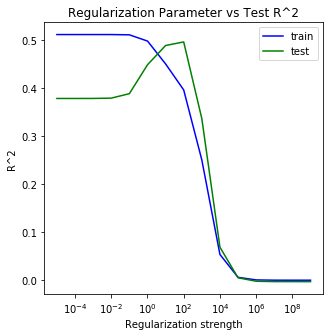

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(reg_params, train_R_sq, color='blue', label='train')
ax.plot(reg_params, test_R_sq, color='green', label='test')

ax.set_xscale('log')
ax.set_title('Regularization Parameter vs Test R^2')
ax.set_xlabel('Regularization strength')
ax.set_ylabel('R^2')
ax.legend(loc='best')

plt.show()

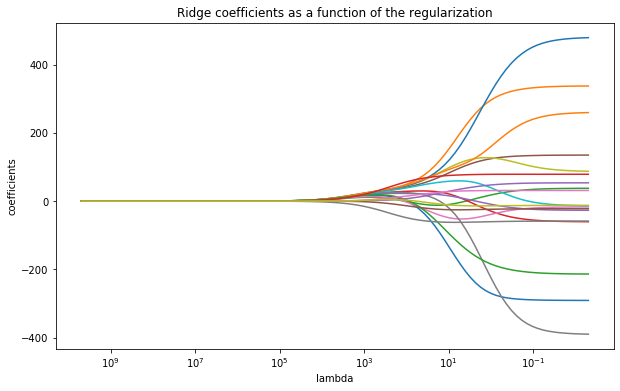

In [24]:
y = df.Salary
# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

alphas = 10**np.linspace(10,-2,100)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('coefficients')
plt.title('Ridge coefficients as a function of the regularization');

### b) LASSO Regression

In [25]:
train_R_sq = []
test_R_sq = []

for reg in reg_params:
    lasso_regression = Lasso(alpha=reg, max_iter=100000, fit_intercept=True)
    lasso_regression.fit(X_non_test, y_non_test)
    
    train_R_sq.append(lasso_regression.score(X_non_test, y_non_test))
    test_R_sq.append(lasso_regression.score(X_test, y_test))

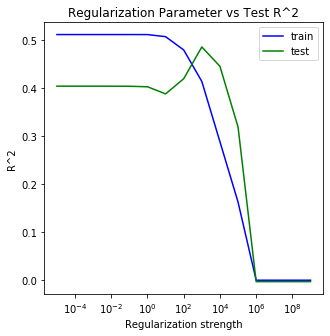

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(reg_params, train_R_sq, color='blue', label='train')
ax.plot(reg_params, test_R_sq, color='green', label='test')

ax.set_xscale('log')
ax.set_title('Regularization Parameter vs Test R^2')
ax.set_xlabel('Regularization strength')
ax.set_ylabel('R^2')
ax.legend(loc='best')

plt.show()

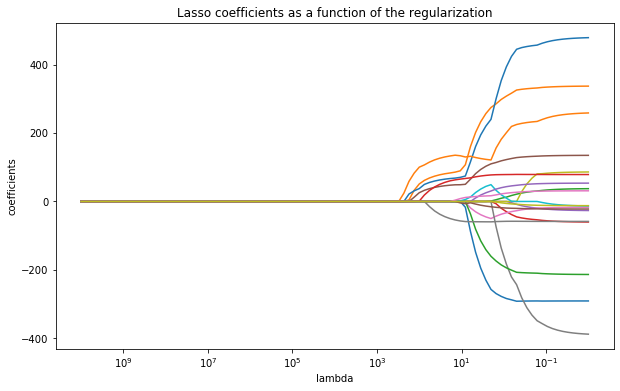

In [27]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X), y)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('coefficients')
plt.title('Lasso coefficients as a function of the regularization');

### Differences between Ridge (L2) and Lasso (L1)

* Ridge regression does have one obvious  disadvantage: unlike subset selection, which will generally select models  that involve just a subset of the variables, ridge regression  will include all p predictors in the final model.

* Lasso forces some of the coefficient estimates to be  exactly equal to zero when the tuning parameter λ is  sufficiently large. Hence, much like best subset selection, the lasso performs variable selection. We say that the lasso yields sparse  models — that  is, models that involve only a subset of  the  variables.

* Why is that? It helps re-formulating a bit the optimization problem of Ridge and Lasso:


$$
\frac{1}{n} \sum_{i = 1}^n (y_i - \mathbf{\beta}^T \mathbf{x}_i)^2 + R(\beta).
$$

or equivalent we minimize:

$$\frac{1}{n} \sum_{i = 1}^n (y_i - \mathbf{\beta}^T \mathbf{x}_i)^2$$

subject on the constraint: $$\sum_{j = 1}^p \beta_j^2 \leq s$$ for Ridge

and $$\sum_{j = 1}^p |\beta_j| \leq s$$ for Lasso.

For $p=2$ predictors, this can be visualized as follows:

![ridgelasso](ridgelasso.png)

The red lines are the contours that the RSS is minimum. What I say to the model, is: "find me the smallest RSS you can get, so that the budget constraint is satisfied"

### 2.3.3 Cross Validation: Selecting the Regularization Parameter (check it at home -- it will come for the clinic as well)

How do I select the regularization parameter? Simply, with cross-validation. In this case, we also use the MSE (mean squared error) as a performance metric. This just puts together what we discussed before (regularization + cross-validation).

In [28]:
X_non_test = np.vstack((X_train, X_val))
y_non_test = np.hstack((y_train, y_val))

kf = KFold(n_splits=10)

x_val_scores = []
mse_val = []

for reg in reg_params:
    ridge_regression = Ridge(alpha=reg, fit_intercept=True)
    
    validation_R_sqs = []
    mses = []
    for train_index, val_index in kf.split(X_non_test):
        X_train, X_val = X_non_test[train_index], X_non_test[val_index]
        y_train, y_val = y_non_test[train_index], y_non_test[val_index]

        
        ridge_regression.fit(scale(X_train), y_train)
        validation_R_sqs.append(ridge_regression.score(scale(X_val), y_val))
        pred = ridge_regression.predict(scale(X_val))
        mses.append(mean_squared_error(y_val, pred))

        
    x_val_scores.append(np.mean(validation_R_sqs))
    mse_val.append(np.mean(mses))

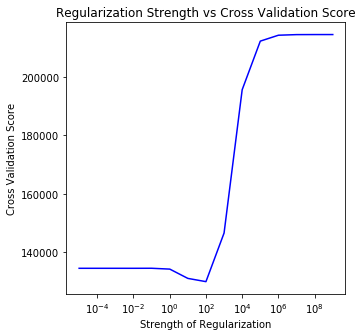

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(reg_params, mse_val, color='blue')

ax.set_xscale('log')
ax.set_title('Regularization Strength vs Cross Validation Score')
ax.set_xlabel('Strength of Regularization')
ax.set_ylabel('Cross Validation Score')

plt.show()

In [30]:
best_alpha = reg_params[np.argmin(mse_val)]

ridge_regression = Ridge(alpha=best_alpha, fit_intercept=True)
ridge_regression.fit(scale(X_non_test), y_non_test)
pred = ridge_regression.predict(scale(X_test))
mse_final = mean_squared_error(y_test, pred)
#test_R_sq = (ridge_regression.score(scale(X_test), y_test))

print('best regularization param is:', best_alpha)
print('the MSE (test set) for ridge regression with alpha = {} is: {}'.format(best_alpha, mse_final))

best regularization param is: 100.01
the MSE (test set) for ridge regression with alpha = 100.01 is: 90716.68965146279


In [31]:
pd.Series(ridge.coef_.flatten(), index=X.columns)

AtBat         -291.006253
Hits           337.528334
HmRun           37.673623
Runs           -60.293410
RBI            -26.829269
Walks          135.000609
Years          -16.872957
CAtBat        -389.910351
CHits           87.649745
CHmRun         -13.534996
CRuns          479.163318
CRBI           259.529823
CWalks        -213.633676
PutOuts         78.761373
Assists         53.694656
Errors         -22.176895
League_N        31.251786
Division_W     -58.429002
NewLeague_N    -12.367081
dtype: float64

### Alternative approaches: Use `RidgeCV` and `LassoCV`

(check the documentation carefully before you apply them)

In [32]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

RidgeCV(alphas=array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+0...
       3.06795364e+00, 2.32079442e+00, 1.75559587e+00, 1.32804389e+00,
       1.00461650e+00, 7.59955541e-01, 5.74878498e-01, 4.34874501e-01,
       3.28966612e-01, 2.48851178e-01, 1.88246790e-01, 1.42401793e-01,
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03]),
        scoring='neg_mean_squared_error')

In [33]:
ridgecv.alpha_

3.0679536367065814

In [34]:
ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge.predict(scale(X_test)))

86281.33281887049

In [35]:
pd.Series(ridge.coef_.flatten(), index=X.columns)

AtBat         -176.084962
Hits           171.602550
HmRun          -13.697325
Runs            -9.261044
RBI              5.977581
Walks          129.622676
Years          -73.198329
CAtBat         -71.292512
CHits          180.333502
CHmRun          66.269477
CRuns          182.403783
CRBI           143.274381
CWalks        -220.119392
PutOuts         68.155871
Assists         31.478836
Errors         -10.478346
League_N        37.257111
Division_W     -81.161046
NewLeague_N    -18.172390
dtype: float64

In [36]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_non_test), y_non_test)

LassoCV(cv=10, max_iter=10000)

In [37]:
lassocv.alpha_

3.127277295558936

In [38]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

85820.00387738158

In [39]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat         -177.559757
Hits           169.314851
HmRun           -3.797022
Runs            -0.000000
RBI             -0.000000
Walks          127.505833
Years          -59.420155
CAtBat          -0.000000
CHits           13.567134
CHmRun           6.031391
CRuns          246.520381
CRBI           226.106869
CWalks        -231.964386
PutOuts         65.468736
Assists         23.136002
Errors          -0.000000
League_N        19.743473
Division_W     -80.448147
NewLeague_N     -0.000000
dtype: float64

## 2.3 Step-wise selection

One straightforward way to think about how to pick among different predictors (variables) in the model would be to try to check *all* combinations between *all* predictors and how much they affect performance. That is called "best subset selection". For computational reasons, best subset selection cannot be applied to datasets with a large number of predictors (why?).

Step-wise selection can then be a viable alternative. We have two options:

* forward selection: we start with one predictor, find the best model with only one predictor (based on a performance metric), move to models with two predictors (by keeping the one predictor fixed) etc.

* backward selection: opposite as above, we start with a model with all predictors and reduce them one by one.

It is not guaranteed to find the best possible model out of all $2^p$ models containing subsets of all predictors (why?).

In [40]:
df = pd.read_csv('Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

In [41]:
df.head()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0    

In [42]:
# Drop the columns for which we created dummy variables
dfnew = df.drop(['League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
dfnew = pd.concat([dfnew, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  Salary       263 non-null    float64
 17  League_N     263 non-null    uint8  
 18  Division_W   263 non-null    uint8

In [43]:
X_train = pd.read_csv('Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('Hitters_y_test.csv', index_col=0)

In [44]:
cols = ['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors',
 'League_N',
 'Division_W',
 'NewLeague_N']

train, validation, test = train_test_split(dfnew, validation=True)

y_train = train['Salary'].values
y_val = validation['Salary'].values
y_test = test['Salary'].values

regression_model = LinearRegression(fit_intercept=True)

### 1. Forward Selection

In [45]:
#all_predictors = credit.columns.tolist()
all_predictors = cols

predictors = [([], 0)]

regression_model = LinearRegression(fit_intercept=True)

R_sq_fwd = []

for k in range(1, len(all_predictors)):
    best_k_minus_1 = predictors[-1][0]

    new_predictors = list(set(all_predictors) - set(best_k_minus_1))
    validation_R_sqs = []

    for predictor in new_predictors:

        k_predictors = best_k_minus_1 + [predictor]
        
        X_train = train[k_predictors].values
        X_val = validation[k_predictors].values
        
        if k == 1:
            X_train = X_train.reshape((len(X_train), 1))
            
        regression_model.fit(X_train, y_train)
        validation_R_sqs.append(regression_model.score(X_val, y_val))
    
    best_k = best_k_minus_1 + [new_predictors[np.argmax(validation_R_sqs)]]
    R_sq_fwd.append(np.max(validation_R_sqs))
    predictors.append((best_k, np.max(validation_R_sqs)))


X_train = train[all_predictors].values
X_val = validation[all_predictors].values  
regression_model.fit(X_train, y_train)

predictors.append((all_predictors, regression_model.score(X_val, y_val)))

In [46]:
best_predictor_set = sorted(predictors, key=lambda t: t[1])[-1]

X_train = train[best_predictor_set[0]].values
X_val = validation[best_predictor_set[0]].values  
X_test = test[best_predictor_set[0]].values  

regression_model.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print('best predictor set: {}\nvalidation R^2: {}\ntest R^2: {}'.format(best_predictor_set[0], best_predictor_set[1], regression_model.score(X_test, y_test)))

best predictor set: ['CRBI', 'Runs', 'Years', 'PutOuts']
validation R^2: 0.5792616875425483
test R^2: 0.5100712759128195


In [47]:
predictors

[([], 0),
 (['CRBI'], 0.42521959156095923),
 (['CRBI', 'Runs'], 0.5697605426867011),
 (['CRBI', 'Runs', 'Years'], 0.5788119250466905),
 (['CRBI', 'Runs', 'Years', 'PutOuts'], 0.5792616875425483),
 (['CRBI', 'Runs', 'Years', 'PutOuts', 'AtBat'], 0.578054686069009),
 (['CRBI', 'Runs', 'Years', 'PutOuts', 'AtBat', 'Errors'], 0.565388828014598),
 (['CRBI', 'Runs', 'Years', 'PutOuts', 'AtBat', 'Errors', 'RBI'],
  0.5525563931847426),
 (['CRBI',
   'Runs',
   'Years',
   'PutOuts',
   'AtBat',
   'Errors',
   'RBI',
   'NewLeague_N'],
  0.5369154595839443),
 (['CRBI',
   'Runs',
   'Years',
   'PutOuts',
   'AtBat',
   'Errors',
   'RBI',
   'NewLeague_N',
   'Division_W'],
  0.5165301272009015),
 (['CRBI',
   'Runs',
   'Years',
   'PutOuts',
   'AtBat',
   'Errors',
   'RBI',
   'NewLeague_N',
   'Division_W',
   'CWalks'],
  0.507653311922907),
 (['CRBI',
   'Runs',
   'Years',
   'PutOuts',
   'AtBat',
   'Errors',
   'RBI',
   'NewLeague_N',
   'Division_W',
   'CWalks',
   'Walks'],
  

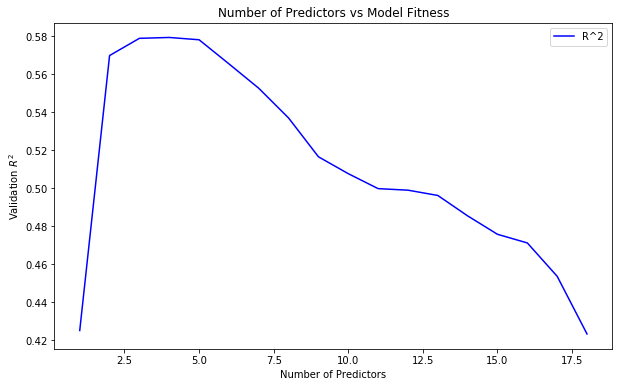

In [48]:
#a very ugly plot, needs improvement
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(range(1, len(predictors)-1 ), R_sq_fwd, color='blue', label='R^2')

ax.set_title('Number of Predictors vs Model Fitness')
ax.set_xlabel('Number of Predictors')
ax.set_ylabel('Validation $R^2$')
ax.legend(loc='best')

plt.show()

### 2. Backwards Selection

Similar processes can be applied to the backward process, i.e. start with all predictors and remove one at each step. Let's see the same process, but introduce another metric here, AIC.

The Akaike Information Criterion (AIC) is an estimator of prediction error and thereby relative quality of statistical models for a given set of data. The AIC criterion is defined for a large class of models fit by maximum likelihood.

$$AIC = -2 \cdot logL +2 \cdot d$$

where $L$ is the maximized value of the likelihood function for the estimated model and $d$ is the total number of parameters (here is the number of predictors).

In the case of  the linear model with Gaussian errors, maximum likelihood and least squares are the same thing. More specifically for the linear model: $ -2 \cdot logL = \frac{RSS}{\sigma^2} $. Obviously, I need to choose the model with the smallest $AIC$ value.

In [49]:
from statsmodels.tools import add_constant
import statsmodels.api as sm1

def get_aic(X_train, y_train):
    X_train = add_constant(X_train)
    model = sm1.OLS(y_train, X_train).fit()
    return model.aic

X_train = train[all_predictors].values
predictors = [(all_predictors, get_aic(X_train, y_train))]

for k in range(len(all_predictors), 1, -1):
    best_k_predictors = predictors[-1][0]
    aics = []
    
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train = train[k_minus_1].values

        aics.append(get_aic(X_train, y_train))
    
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmin(aics)]]))
    predictors.append((best_k_minus_1, np.min(aics)))

In [50]:
best_predictor_set = sorted(predictors, key=lambda t: t[1])[0]

X_train = train[best_predictor_set[0]].values
X_val = validation[best_predictor_set[0]].values  
X_test = test[best_predictor_set[0]].values  
regression_model.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print('best predictor set: {}\nAIC: {}\ntest R^2: {}'.format(best_predictor_set[0], best_predictor_set[1], regression_model.score(X_test, y_test)))

best predictor set: ['Assists', 'AtBat', 'Walks', 'CRuns', 'League_N', 'CWalks', 'Division_W', 'Hits', 'PutOuts', 'Years', 'CRBI', 'Runs']
AIC: 2087.5493967156344
test R^2: 0.5463905292129578


# 3. Extensions of the linear model

The linear model can be generalized into many different variations:

* Classification problems: Logistic regression, etc.

* Non-linearity: splines, generalized additive models, etc.

* Interactions: Tree-based methods (bagging, boosting, etc.)

* Regularized fitting: We covered this already!